# Eigengene Single-Variant Association Exploration

**Created**: 25 November 2021

## Environment

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

In [2]:
library(tidyverse)
library(RColorBrewer)
library(ComplexHeatmap)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and co

## Load Data

In [3]:
demographics <- readxl::read_xls("/nfs/team282/data/gains_team282/ClinicalData/DEMO_12jun2019.xls", sheet=1) %>%
    dplyr::mutate(sex=as.numeric(sex)) %>%
    dplyr::mutate(diagnosis=as.numeric(diagnosis))

ga.prefix.index <- grepl("GA", demographics$SubjectBarCode)
demographics$SubjectBarCode[ga.prefix.index] <- gsub("^GA", "", demographics$SubjectBarCode[ga.prefix.index])

In [4]:
srs.info <- read.table("/nfs/team282/data/gains_team282/full-gains-SRS-predictions_mNN-RF.tsv", header=T)
ga.prefix.index <- grepl("GA", srs.info$Sample_id)
srs.info$Sample_id[ga.prefix.index] <- gsub("^GA", "", srs.info$Sample_id[ga.prefix.index])
srs.info <- srs.info %>%
  dplyr::filter(Assay=="RNA-seq")
row.names(srs.info) <- srs.info$Sample_id

In [5]:
covs <- read.table("~/gains_team282/eqtl/data/covs_and_peer_factors.txt") %>%
    dplyr::mutate(Sample.ID=rownames(.)) %>%
    dplyr::mutate(GAinS.ID=sapply(strsplit(Sample.ID, "_"), function(x) { x[1] }))

ga.prefix.index <- grepl("GA", covs$GAinS.ID)
covs$GAinS.ID[ga.prefix.index] <- gsub("^GA", "", covs$GAinS.ID[ga.prefix.index])
covs$Sample.ID[ga.prefix.index] <- gsub("^GA", "", covs$Sample.ID[ga.prefix.index])

In [6]:
held.out <- c("Neutrophils", "Lymphocytes", "Monocytes", paste0("PC", 1:7), "Diagnosis", "SRSq", "sex")
peer <- paste0("PEER_", 1:30)

covs <- covs %>%
    merge(., demographics, by.x="GAinS.ID", by.y="SubjectBarCode") %>%
    merge(., srs.info, by.x="Sample.ID", by.y=0) %>%
    dplyr::select(diagnosis=diagnosis, everything()) %>%
    dplyr::select(Sample.ID, any_of(held.out), any_of(peer)) %>%
    as.data.frame()
                                  
rownames(covs) <- covs$Sample.ID
covs <- covs %>%
    dplyr::select(-Sample.ID)
                                  
head(covs)

,Neutrophils,Lymphocytes,Monocytes,PC1,PC2,PC3,PC4,PC5,PC6,PC7,⋯,PEER_21,PEER_22,PEER_23,PEER_24,PEER_25,PEER_26,PEER_27,PEER_28,PEER_29,PEER_30
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK01050129_5,-1.7381318,1.8281826,1.2829455,0.177279994,0.051694602,0.02486030,-0.035102502,-0.00455149,-0.0603707,0.03964880,⋯,-0.001172263,-0.05533835,0.049742281,0.03725176,0.04495762,0.12696229,0.08175036,0.05295999,0.164950684,-0.10379386
UK01060123_3,-0.3845370,0.3878375,0.4548023,-0.000388133,-0.000674099,0.00810357,0.000212791,0.03396150,0.0266317,-0.01885280,⋯,-0.012723563,0.02226736,-0.027520355,-0.05782387,0.03653939,0.05959492,-0.02611259,-0.01790827,0.012047987,0.05554044
UK01070117_3,-0.7738039,0.5846032,0.9325467,0.016432300,-0.048464298,0.00813966,-0.047699600,-0.07926830,0.0263629,-0.08224740,⋯,0.040162142,0.06840651,0.000062529,0.05292596,0.01705806,0.05931079,0.08962730,0.03772458,0.008254956,-0.01570964
UK01080111_1,0.1305646,0.2888638,-0.6232047,0.161789000,0.036224801,0.00467903,-0.048611499,0.00180036,-0.0352357,0.05012510,⋯,-0.002928361,-0.03274319,0.088269033,0.07396927,-0.01906336,0.02454052,0.04243371,0.03055887,0.123383760,-0.02276623
UK01110093_1,1.0909779,-1.2488160,-0.4429439,-0.006296720,0.002821510,0.00699239,0.004351650,0.00268802,0.0166922,-0.00733983,⋯,-0.108193189,0.01590979,-0.093242317,-0.03037383,-0.07385907,-0.05968965,0.09695430,-0.03975484,0.130198911,-0.05011296
UK01110093_5,0.2302416,0.0000000,-0.3306479,-0.006296720,0.002821510,0.00699239,0.004351650,0.00268802,0.0166922,-0.00733983,⋯,-0.018054215,0.02094322,-0.008623131,0.09560122,-0.07802416,0.02365689,0.08040638,-0.02349218,0.189585552,-0.07635343


In [8]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.clr.csv", row.names=1)

head(eigengenes)

,ME_1,ME_2,ME_3,ME_4,ME_5,ME_6,ME_7,ME_8,ME_9,ME_10,⋯,ME_17,ME_18,ME_19,ME_20,ME_21,ME_22,ME_23,ME_24,ME_25,ME_26
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UK02270173_3,-0.01611500,-8.739980e-03,0.017559222,-0.027088697,-0.014542344,-0.051399999,0.046803451,-0.034436746,-0.039087399,0.007150941,⋯,-0.028049775,-0.008129458,-0.0366723556,-0.025875130,-0.028752001,-0.029350268,-0.033465625,0.010493801,0.00122623,-0.024552444
UK15130120_3,0.02461525,6.068727e-05,0.019840461,-0.001849399,0.015906557,-0.042843776,0.027117922,0.008308366,-0.052541896,0.002858297,⋯,-0.051424350,0.032422585,-0.0460940914,-0.020925083,-0.045620906,0.001037124,-0.046257297,-0.006227393,0.03094529,-0.009247218
UK58000006_3,-0.02437838,-2.023844e-02,0.011494096,-0.016979651,-0.012391572,-0.013535154,0.028149929,-0.036083414,0.006142253,-0.012787746,⋯,0.003129053,-0.042368235,-0.0007423982,-0.016100324,-0.004058335,-0.004009045,-0.033120185,0.022609639,-0.02542599,-0.015154949
UK47010004_3,-0.01080795,8.698390e-03,0.007577865,0.013627892,-0.004619325,0.002682967,-0.009939209,0.006247252,0.002732679,0.019114337,⋯,0.011108371,-0.017369738,-0.0004493176,-0.008345582,0.019301199,-0.016442041,0.005647093,0.014716956,-0.01134338,0.010130191
UK42020088_5,-0.01290457,3.118465e-02,0.015750574,-0.011878781,-0.017614265,0.003339252,0.002623253,-0.001437406,0.001814986,0.002952335,⋯,-0.003885891,0.029755732,-0.0015589206,0.031183587,-0.011606689,-0.007412970,0.003816931,-0.025490423,0.02710027,-0.015256640
UK47490007_3,0.01069874,3.416032e-02,0.013941807,0.025513984,0.009282998,0.008292475,-0.022579807,0.027908019,-0.012258133,-0.053561098,⋯,-0.018626363,0.027655567,-0.0135092661,-0.027328549,-0.005307802,-0.020544032,-0.016863817,0.000202337,0.02977359,-0.003884780


## Heatmap

Before performing single-variant association analysis, we want to check if the signal present in the eigengenes is captured by one of the PEER factors.

In [9]:
all.vars <- merge(covs, eigengenes, by.x=0, by.y=0) %>%
    dplyr::select(-Row.names)

In [11]:
colors <- colorRampPalette(brewer.pal(11, "RdBu"))(101)

cor.mtx <- cor(all.vars)
cor.mtx.peer <- cor.mtx[peer, colnames(eigengenes)]
cor.mtx.held.out <- cor.mtx[held.out, colnames(eigengenes)]

h1 <- Heatmap(cor.mtx.peer, col=colors, heatmap_legend_param=list(
    title="Correlation",
    at=c(-1, 0, 1)
))

h2 <- Heatmap(cor.mtx.held.out, col=colors, cluster_rows=F, heatmap_legend_param=list(
    title="Correlation",
    at=c(-1, 0, 1)
))

svg("04_Expression/results/eigengene_peer_factor_correlation.svg", width=8, height=8)
h1 %v% h2
dev.off()

png 
  2

The PEER factors are built using gene expression data. It's not surprising that many of the eigengenes are associated with the PEER factors. WGCNA discarded around 8000 genes. The residual gene expression variation from these genes is likely captured by some of the PEER factors.

The eigengenes are not associated with genotyping PCs (which is good).

![](../results/eigengene_peer_factor_correlation.svg)

Ideally, I will include only sex and genotyping PCs as covariates in this mapping, since everything else (cell counts, SRS group) are important signatures that may be correlated with module eigengenes. I will include PEER factors that are not highly correlated with module eigengenes, since they represent residual variation from the ~8000 genes not included in the modules.

Here, I'm using the elbow method to determine which PEER factors are not too correlated with the module eigengenes. For each PEER factor, I calculate the maximum absolute correlation for the set of all eigengenes. The elbow is at around $|\rho| < 0.4$.

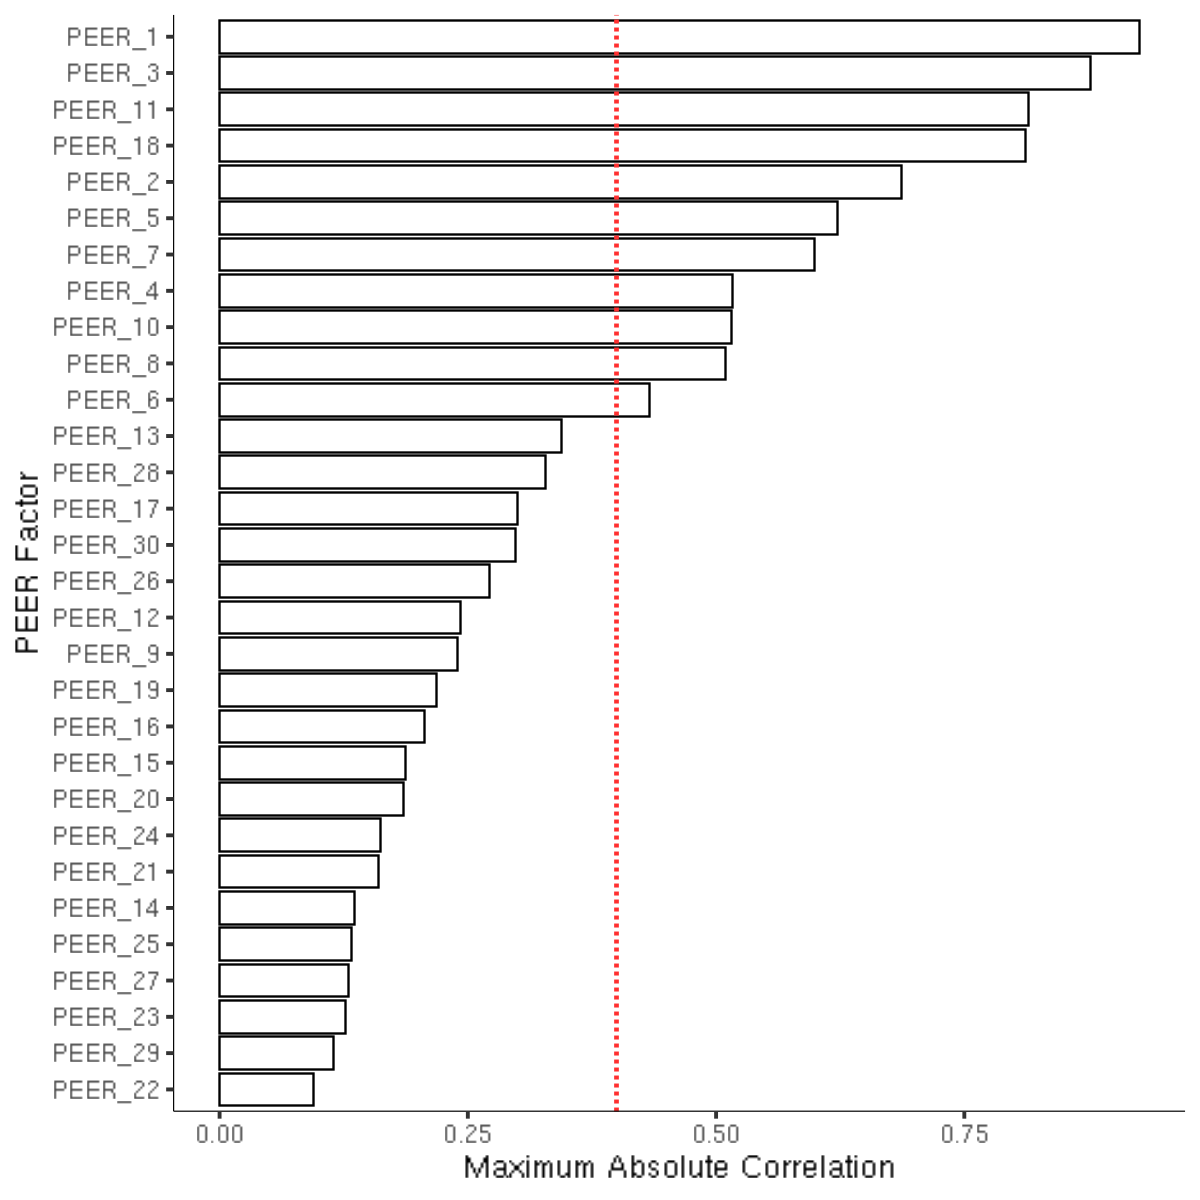

In [12]:
options(repr.plot.width=10, repr.plot.height=10)
as.data.frame(apply(abs(cor.mtx.peer), 1, max)) %>%
    dplyr::select(Max.Abs.Cor=1) %>%
    dplyr::arrange(Max.Abs.Cor) %>%
    dplyr::mutate(PEER.Factor=rownames(.)) %>%
    dplyr::mutate(PEER.Factor=factor(PEER.Factor, levels=PEER.Factor)) %>%
    ggplot() +
    geom_bar(aes(x=PEER.Factor, y=Max.Abs.Cor), stat="identity", color="black", fill="white") +
    geom_hline(aes(yintercept=0.4), lty=2, color="firebrick1", size=I(1)) +
    xlab("PEER Factor") + ylab("Maximum Absolute Correlation") +
    coord_flip() +
    ggplot_theme
ggsave("04_Expression/results/eigengene_peer_factor_maximum_absolute_correlation.svg", width=10, height=10)

In [13]:
peer.factor.names <- names(which(apply(abs(cor.mtx.peer), 1, max) < 0.4))

## Save Covariates

Save list of patients (family ID in the first column and individual ID in the second column) to subset the genotyping data using PLINK. There are 638 unique patients with genotyping information.

In [14]:
eigengene.patients <- sapply(strsplit(rownames(eigengenes), "_"), function(x) { x[1] })

geno.fam <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.fam") %>%
    dplyr::select(Family.ID=1, Individual.ID=2) %>%
    dplyr::mutate(GAinS.ID=gsub("^GA", "", Individual.ID)) %>%
    dplyr::filter(GAinS.ID %in% eigengene.patients) %>%
    unique()

In [15]:
dim(geno.fam)

[1] 638   3

In [16]:
write.table(
    geno.fam %>% dplyr::select(Family.ID, Individual.ID), 
    "~/gains_team282/nikhil/expression/eigengene_sva/mapping_patients.txt", row.names=F, quote=F, col.names=F, sep="\t"
)

Save the list of module eigengenes as a text file. This will be used by NextFlow to parallelize the association mapping.

In [17]:
write.table(colnames(eigengenes), "~/gains_team282/nikhil/expression/eigengene_sva/mapping_eigengenes.txt", row.names=F, quote=F, col.names=F, sep="\t")

### Initial Pass

I will be using a linear mixed model (LMM) to test for association between genotypes and eigengene expression. In the past, the lab has used a likelihood test (F-Test) to compare a null model of the covariates against an alternative model where the genotype is included. I will be building the following model:

1. Let $\mathbf{E}_i\in\mathbb{R}^n$ be a vector representing the values of the $i$-th eigengene.
2. Let $\mathbf{Y}\in\mathbb{R}^{n\times c}$ be a matrix of covariates. These covariates include Sex, 16 PEER factors, and 7 Genotyping PCs.
3. Let $\mathbf{Z}\in\mathbb{R}^n$ be a vector representing the random effects. The only random effect in this model is the Patient ID.
4. Let $\mathbf{X}\in\mathbb{R}^n$ be a vector representing the genotypes of the patients.
5. Let $\beta\in\mathbb{R}$ be a scalar value representing the genotypic effect on eigengene expression.
6. Let $\mathbf{\alpha}\in\mathbb{R}^c$ be a vector of covariate effects on eigengene expression.
7. Let $\gamma\in\mathbb{R}$ be a scalar value representing the random effect on eigengene expression.

The null model is:

$$\mathbf{E}_i \sim \mathbf{Y}\alpha + \mathbf{Z}\gamma$$

The alternative model is:

$$\mathbf{E}_i \sim \mathbf{X}\beta + \mathbf{Y}\alpha + \mathbf{Z}\gamma$$

There are 823 samples from the RNA-Seq data that have genotypes as well.

In [18]:
samples.with.genotypes <- rownames(eigengenes)[
    sapply(
        strsplit(rownames(eigengenes), "_"),
        function(x) { x[1] %in% geno.fam$GAinS.ID }
    )
]

length(samples.with.genotypes)

[1] 823

In [19]:
peer.factor.names

eigen.names <- colnames(eigengenes)
eigen.names

cov.names <- c("sex", paste0("PC", 1:7))
cov.names

rand.effect.names <- c("GAinS.ID")
rand.effect.names

[1] "PEER_9"  "PEER_12" "PEER_13" "PEER_14" "PEER_15" "PEER_16" "PEER_17"
 [8] "PEER_19" "PEER_20" "PEER_21" "PEER_22" "PEER_23" "PEER_24" "PEER_25"
[15] "PEER_26" "PEER_27" "PEER_28" "PEER_29" "PEER_30"

[1] "ME_1"  "ME_2"  "ME_3"  "ME_4"  "ME_5"  "ME_6"  "ME_7"  "ME_8"  "ME_9" 
[10] "ME_10" "ME_11" "ME_12" "ME_13" "ME_14" "ME_15" "ME_16" "ME_17" "ME_18"
[19] "ME_19" "ME_20" "ME_21" "ME_22" "ME_23" "ME_24" "ME_25" "ME_26"

[1] "sex" "PC1" "PC2" "PC3" "PC4" "PC5" "PC6" "PC7"

[1] "GAinS.ID"

In [20]:
mapping.data <- merge(eigengenes[samples.with.genotypes,], covs[samples.with.genotypes,], by.x=0, by.y=0) %>%
    dplyr::mutate(GAinS.ID.NonPrefix=sapply(strsplit(Row.names, "_"), function(x) { x[1] })) %>%
    merge(., geno.fam, by.x="GAinS.ID.NonPrefix", by.y="GAinS.ID") %>%
    dplyr::select(GAinS.ID=Individual.ID, everything()) %>%
    dplyr::select(Sample.ID=Row.names, any_of(rand.effect.names), any_of(eigen.names), any_of(cov.names), any_of(peer.factor.names))

Save the mapping data design matrix for linear mixed modeling.

In [21]:
write.csv(mapping.data, "~/gains_team282/nikhil/expression/eigengene_sva/mapping_data.csv", row.names=F)

### Additional Covariates

The initial pass demonstrated that cell proportions are confounders for detecting mQTL. I will add these to the covariates.

1. Let $\mathbf{E}_i\in\mathbb{R}^n$ be a vector representing the values of the $i$-th eigengene.
2. Let $\mathbf{Y}\in\mathbb{R}^{n\times c}$ be a matrix of covariates. These covariates include Sex, Neutrophils, Lymphocytes, Monocytes, 16 PEER factors, and 7 Genotyping PCs.
3. Let $\mathbf{Z}\in\mathbb{R}^n$ be a vector representing the random effects. The only random effect in this model is the Patient ID.
4. Let $\mathbf{X}\in\mathbb{R}^n$ be a vector representing the genotypes of the patients.
5. Let $\beta\in\mathbb{R}$ be a scalar value representing the genotypic effect on eigengene expression.
6. Let $\mathbf{\alpha}\in\mathbb{R}^c$ be a vector of covariate effects on eigengene expression.
7. Let $\gamma\in\mathbb{R}$ be a scalar value representing the random effect on eigengene expression.

The null model is:

$$\mathbf{E}_i \sim \mathbf{Y}\alpha + \mathbf{Z}\gamma$$

The alternative model is:

$$\mathbf{E}_i \sim \mathbf{X}\beta + \mathbf{Y}\alpha + \mathbf{Z}\gamma$$

There are 823 samples from the RNA-Seq data that have genotypes as well.

In [22]:
samples.with.genotypes <- rownames(eigengenes)[
    sapply(
        strsplit(rownames(eigengenes), "_"),
        function(x) { x[1] %in% geno.fam$GAinS.ID }
    )
]

length(samples.with.genotypes)

[1] 823

In [23]:
peer.factor.names

eigen.names <- colnames(eigengenes)
eigen.names

cov.names <- c("sex", "Neutrophils", "Lymphocytes", "Monocytes", paste0("PC", 1:7))
cov.names

rand.effect.names <- c("GAinS.ID")
rand.effect.names

[1] "PEER_9"  "PEER_12" "PEER_13" "PEER_14" "PEER_15" "PEER_16" "PEER_17"
 [8] "PEER_19" "PEER_20" "PEER_21" "PEER_22" "PEER_23" "PEER_24" "PEER_25"
[15] "PEER_26" "PEER_27" "PEER_28" "PEER_29" "PEER_30"

[1] "ME_1"  "ME_2"  "ME_3"  "ME_4"  "ME_5"  "ME_6"  "ME_7"  "ME_8"  "ME_9" 
[10] "ME_10" "ME_11" "ME_12" "ME_13" "ME_14" "ME_15" "ME_16" "ME_17" "ME_18"
[19] "ME_19" "ME_20" "ME_21" "ME_22" "ME_23" "ME_24" "ME_25" "ME_26"

[1] "sex"         "Neutrophils" "Lymphocytes" "Monocytes"   "PC1"        
 [6] "PC2"         "PC3"         "PC4"         "PC5"         "PC6"        
[11] "PC7"

[1] "GAinS.ID"

In [24]:
mapping.data <- merge(eigengenes[samples.with.genotypes,], covs[samples.with.genotypes,], by.x=0, by.y=0) %>%
    dplyr::mutate(GAinS.ID.NonPrefix=sapply(strsplit(Row.names, "_"), function(x) { x[1] })) %>%
    merge(., geno.fam, by.x="GAinS.ID.NonPrefix", by.y="GAinS.ID") %>%
    dplyr::select(GAinS.ID=Individual.ID, everything()) %>%
    dplyr::select(Sample.ID=Row.names, any_of(rand.effect.names), any_of(eigen.names), any_of(cov.names), any_of(peer.factor.names))

Save the mapping data design matrix for linear mixed modeling.

In [25]:
write.csv(mapping.data, "~/gains_team282/nikhil/expression/eigengene_sva/mapping_data_cell_proportions.csv", row.names=F)